In [1]:
import matplotlib.pyplot as plt
import gensim
import numpy as np
import spacy

In [2]:
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary

In [3]:
import pyLDAvis.gensim

In [4]:
import os, re, operator, warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#import pandas as pd

In [5]:
PATH='./'
#filename = f'{PATH}1965-1212_Communion_ENG_12-1201-B123E1R-x-top.txt'

In [6]:
'''
# consider each row/rsub a document for now
df = pd.read_csv(filename, delimiter='|', skiprows=1, header=None,
                     #index_col=0, 
                     low_memory=False
                    )
print(df.shape)
df.columns = ['rsub','text']
df.head()
'''

"\n# consider each row/rsub a document for now\ndf = pd.read_csv(filename, delimiter='|', skiprows=1, header=None,\n                     #index_col=0, \n                     low_memory=False\n                    )\nprint(df.shape)\ndf.columns = ['rsub','text']\ndf.head()\n"

In [7]:
#df = pd.read_pickle(f'{PATH}topic-pre.pkl')

In [8]:
##from spacy.en import English
nlp = spacy.load('en') #load English lanuage model
#nlp = spacy.load('en_core_web_lg')
#nlp = spacy.load('en_core_web_sm')

In [9]:
#Due to BUG: https://github.com/explosion/spaCy/issues/1574
for word in nlp.Defaults.stop_words:
    for w in (word, word[0].upper() + word[1:], word.upper()):
        lex = nlp.vocab[w]
        lex.is_stop = True

In [10]:
#from spacy.lang.en.stop_words import STOP_WORDS
#print(STOP_WORDS)
#print(len(STOP_WORDS))

In [11]:
print(f"word: {nlp.vocab['Thing'].is_stop}")

word: False


In [12]:
#add my own stop words (in addition to what spacy has for English)
#this does not seem to work anymore, see URL below
#my_stop_words = [u'say', u'\'s', u'Mr', u'be', u'said', u'says', u'saying']

my_stop_words = ['said','Said','saying','Saying','thing','things','Thing','Things','man','day','church','Church','people','People','time',
                'way','ways','Way','Ways','place','places','Place','Places','hand','age','ages','world','worlds','tonight','Tonight',
                'day','days','Day','Days','brother','brothers','Brother','Brothers','sister','sisters','Sister','Sisters',
                'woman','women','year','years','chapter','chapters','verse','verses','today','Today','mammy','Mammy','hand','Hand']
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

In [13]:
print(nlp.vocab['way'].is_stop)

True


In [14]:
#https://stackoverflow.com/questions/41170726/add-remove-stop-words-with-spacy
#nlp.Defaults.stop_words |= {'And','Say','See','what','thing','something',}
#print(nlp.Defaults.stop_words)
#print(len(nlp.Defaults.stop_words))

In [15]:
'''
from spacy.lang.en.stop_words import STOP_WORDS
print(STOP_WORDS) # <- set of Spacy's default stop words
print(len(STOP_WORDS))

#MY_STOP_WORDS = ['and','say','see','what','thing','something']
##for i,word in enumerate(MY_STOP_WORDS):
STOP_WORDS.add("'and'")
STOP_WORDS.add("'say'")

for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

print(STOP_WORDS) # <- set of Spacy's default stop words
print(len(STOP_WORDS))
'''

'\nfrom spacy.lang.en.stop_words import STOP_WORDS\nprint(STOP_WORDS) # <- set of Spacy\'s default stop words\nprint(len(STOP_WORDS))\n\n#MY_STOP_WORDS = [\'and\',\'say\',\'see\',\'what\',\'thing\',\'something\']\n##for i,word in enumerate(MY_STOP_WORDS):\nSTOP_WORDS.add("\'and\'")\nSTOP_WORDS.add("\'say\'")\n\nfor word in STOP_WORDS:\n    lexeme = nlp.vocab[word]\n    lexeme.is_stop = True\n\nprint(STOP_WORDS) # <- set of Spacy\'s default stop words\nprint(len(STOP_WORDS))\n'

In [47]:
#read complete file: gives a list of strings, each string a title/sermon
#with open('all_titles_test.csv', 'r', encoding='utf-8') as f_all:
with open('all_titles.csv', 'r', encoding='utf-8') as f_all:
    all_lines = f_all.readlines() #each string must be a title/sermon
print(len(all_lines))
#all_lines

13


In [17]:
# clean text: remove stopwords, only alphanumeric tokens, remove punctuation tokens, remove numbers, lemmas of tokens
# generate list of words for each document (row)
def clean(text):
    #removal=['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE']
    text_out = []
    ##utext = unicode(text, "utf-8")
    ##utext = text.encode('utf-8')
    #utext = text
    #doc = nlp(utext)
    doc = nlp(text)
    for tok in doc:
        #if tok.is_stop == False and tok.is_alpha and len(tok)>2 and tok.pos_ not in removal:
        #if not tok.is_stop and tok.is_alpha and not tok.is_punct and not tok.like_num and len(tok)>2:
        #if tok.pos_=='NOUN':
        if not tok.is_stop and tok.is_alpha and not tok.is_punct and not tok.like_num and len(tok)>2 and tok.pos_=='NOUN':
            lemma = tok.lemma_
            text_out.append(lemma)
    #return list(text_out)
    return text_out

In [18]:
processed_corpus = []
line = "Brother Sister at the sea When And they Say their See forever Said saying Saying thing man day people People"
#lst = line.split()
print(line)
clean_line = clean(line)#; print(type(clean_line))
#print(clean_line)

processed_corpus.append(clean_line)
processed_corpus
processed_corpus.append(clean_line)
processed_corpus

Brother Sister at the sea When And they Say their See forever Said saying Saying thing man day people People


[['sea'], ['sea']]

In [19]:
#takes a while
processed_corpus = []
for line in all_lines: #each line is a title/sermon
    ##processed_corpus.append(clean(line.split()))
    clean_line = clean(line)
    processed_corpus.append(clean_line)
type(processed_corpus)

list

In [20]:
print(processed_corpus[0][0:100])
#print(processed_corpus)
#processed_corpus

['spot', 'tape', 'evening', 'friend', 'privilege', 'staff', 'church', 'bosom', 'friend', 'water', 'hand', 'folk', 'telephone', 'hookup', 'country', 'part', 'nation', 'system', 'telephone', 'blessing', 'friend', 'gadget', 'television', 'set', 'telephone', 'television', 'set', 'organ', 'friend', 'folk', 'tabernacle', 'half', 'tabernacle', 'friend', 'request', 'faith', 'second', 'devil', 'lie', 'yesterday', 'friend', 'feeling', 'welcome', 'friend', 'trail', 'horse', 'jungle', 'emergency', 'platform', 'hitchhiker', 'help', 'blessing', 'grace', 'mercy', 'group', 'greeting', 'church', 'hour', 'service', 'friend', 'author', 'moment', 'head', 'heart', 'privilege', 'begotten', 'whosoever', 'pilgrimage', 'earth', 'judgment', 'death', 'begotten', 'heart', 'nation', 'minister', 'pulpit', 'pastor', 'wife', 'child', 'deacon', 'trustee', 'board', 'light', 'hour', 'privilege', 'land', 'crack', 'corner', 'nation', 'judgment', 'fault', 'nation', 'earthquake', 'diver', 'past', 'judgment', 'prophecy', 'co

In [21]:
#all_text = ' '.join(all_lines) #a single line is too long - longer than 1,000,000 (limit by gensim); so rather call nlp on each doc - docs are separated by NLs here

In [22]:
'''
texts, title = [], []
for w in all_text:
    #add conditionally to title/article
    if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num:
        title.append(w.lemma_)
    #if this word is newline, start the next title
    if w.text == '\n':
        texts.append(title)
        title = []
'''

"\ntexts, title = [], []\nfor w in all_text:\n    #add conditionally to title/article\n    if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num:\n        title.append(w.lemma_)\n    #if this word is newline, start the next title\n    if w.text == '\n':\n        texts.append(title)\n        title = []\n"

In [23]:
'''
#apply to text of each doc from df
corp = df.text.apply(lambda x:clean(x)); print(type(corp))
corp[:10] #first 20 docs
'''

'\n#apply to text of each doc from df\ncorp = df.text.apply(lambda x:clean(x)); print(type(corp))\ncorp[:10] #first 20 docs\n'

In [24]:
'''
#convert Series to list
processed_corpus = list(corp); type(processed_corpus)
print(processed_corpus) #corpus is now list of lists (for gensim)
#processed_corpus[:2]
'''

'\n#convert Series to list\nprocessed_corpus = list(corp); type(processed_corpus)\nprint(processed_corpus) #corpus is now list of lists (for gensim)\n#processed_corpus[:2]\n'

In [25]:
#don't use for now
#use bigrams
#bigram = gensim.models.Phrases(processed_corpus); print(type(bigram))
#print(bigram.vocab)

In [26]:
#don't use for now
#processed_corpus = [bigram[line] for line in processed_corpus] #overwrite corpus with bigram version
#processed_corpus[2][0:100]

In [27]:
#create dictionary
#dictionary = gensim.corpora.Dictionary(corp) #also works on Series
dictionary = gensim.corpora.Dictionary(processed_corpus)
print(dictionary)
#print(dictionary.token2id)

Dictionary(2486 unique tokens: ['air', 'alarm', 'altar', 'animal', 'anybody']...)


In [28]:
#https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.filter_extremes.html
#https://stackoverflow.com/questions/36653882/getting-tf-idf-scores-of-words-using-gensim
#dictionary.filter_extremes(no_below=20, no_above=0.2) #??

In [29]:
#desikan example
#bow_corpus = [dictionary.doc2bow(doc) for doc in processed_corpus]
#bow_corpus

In [30]:
# convert our corpus into document-term matrix
#doc_term_matrix = [dictionary.doc2bow(doc) for doc in corp] #also works on Series
doc_term_matrix = [dictionary.doc2bow(doc) for doc in processed_corpus]; print(type(doc_term_matrix))

<class 'list'>


In [31]:
#first entry in each tuple is the ID of the token in the dictionary, 
#the second is the count of this token in this document
#doc_term_matrix[0:2]
#doc_term_matrix[7:9] #docs 7 to <9

In [32]:
#topic models

In [33]:
#Latent Semantic Indexing
lsi_model = LsiModel(corpus=doc_term_matrix, id2word=dictionary, num_topics=20); print(lsi_model)
lsi_model.print_topics()

LsiModel(num_terms=2486, num_topics=20, decay=1.0, chunksize=20000)


[(0,
  '0.257*"prophet" + 0.233*"life" + 0.223*"heart" + 0.193*"message" + 0.192*"word" + 0.172*"child" + 0.160*"hand" + 0.148*"dove" + 0.147*"denomination" + 0.146*"night"'),
 (1,
  '-0.716*"dove" + -0.340*"wing" + -0.177*"hand" + -0.164*"sign" + 0.134*"child" + 0.129*"denomination" + -0.121*"love" + -0.119*"snow" + -0.117*"bird" + -0.086*"faith"'),
 (2,
  '0.651*"thirst" + 0.299*"water" + 0.261*"soul" + -0.197*"prophet" + 0.164*"deer" + -0.136*"message" + 0.123*"desire" + 0.122*"body" + -0.105*"denomination" + 0.096*"light"'),
 (3,
  '-0.436*"prophet" + 0.304*"child" + 0.234*"life" + 0.213*"mother" + -0.181*"thirst" + 0.157*"boy" + -0.155*"morning" + -0.145*"ark" + 0.143*"body" + 0.119*"father"'),
 (4,
  '0.307*"denomination" + -0.249*"eye" + -0.232*"inspiration" + -0.228*"mother" + -0.189*"boy" + -0.173*"prophet" + 0.170*"husband" + -0.161*"faith" + 0.138*"altar" + 0.128*"message"'),
 (5,
  '-0.215*"king" + 0.210*"faith" + -0.200*"choice" + -0.197*"boy" + 0.196*"inspiration" + -0.19

In [46]:
#Latent Dirichlet Allocation
lda_model = LdaModel(corpus=doc_term_matrix, id2word=dictionary, num_topics=20, passes=100); print(lda_model) #, passes=10 ?
#lda_model.print_topics(3)
lda_model.print_topics()

LdaModel(num_terms=2486, num_topics=20, decay=0.5, chunksize=2000)


[(0,
  '0.000*"water" + 0.000*"thirst" + 0.000*"heart" + 0.000*"word" + 0.000*"life" + 0.000*"prophet" + 0.000*"hand" + 0.000*"message" + 0.000*"dove" + 0.000*"denomination"'),
 (1,
  '0.000*"prophet" + 0.000*"life" + 0.000*"heart" + 0.000*"child" + 0.000*"message" + 0.000*"word" + 0.000*"scripture" + 0.000*"wheat" + 0.000*"son" + 0.000*"denomination"'),
 (2,
  '0.061*"thirst" + 0.031*"water" + 0.026*"soul" + 0.016*"deer" + 0.012*"hand" + 0.012*"desire" + 0.012*"body" + 0.011*"life" + 0.010*"dog" + 0.010*"light"'),
 (3,
  '0.000*"prophet" + 0.000*"heart" + 0.000*"child" + 0.000*"message" + 0.000*"scripture" + 0.000*"hand" + 0.000*"night" + 0.000*"life" + 0.000*"wheat" + 0.000*"eye"'),
 (4,
  '0.000*"prophet" + 0.000*"life" + 0.000*"heart" + 0.000*"word" + 0.000*"hand" + 0.000*"child" + 0.000*"mother" + 0.000*"son" + 0.000*"message" + 0.000*"body"'),
 (5,
  '0.019*"denomination" + 0.016*"door" + 0.015*"heart" + 0.015*"gate" + 0.015*"sacrifice" + 0.013*"bread" + 0.012*"message" + 0.012*"

In [35]:
#Hierarchical Dirichlet Process
hdp_model = HdpModel(corpus=doc_term_matrix, id2word=dictionary); print(hdp_model)
hdp_model.print_topics()

[(0,
  '0.024*prophet + 0.011*heart + 0.011*child + 0.010*word + 0.009*message + 0.009*boy + 0.009*mother + 0.008*king + 0.008*morning + 0.008*denomination'),
 (1,
  '0.022*thirst + 0.012*life + 0.012*water + 0.010*soul + 0.010*word + 0.010*child + 0.009*denomination + 0.009*heart + 0.008*husband + 0.007*body'),
 (2,
  '0.015*heart + 0.015*prophet + 0.013*life + 0.012*eye + 0.012*faith + 0.010*inspiration + 0.010*denomination + 0.010*scripture + 0.009*word + 0.009*night'),
 (3,
  '0.018*body + 0.017*life + 0.015*child + 0.013*earth + 0.010*son + 0.010*hand + 0.010*word + 0.009*death + 0.009*mother + 0.008*daughter'),
 (4,
  '0.052*dove + 0.025*wing + 0.017*hand + 0.014*sign + 0.012*love + 0.009*faith + 0.009*night + 0.009*snow + 0.009*bird + 0.008*water'),
 (5,
  '0.013*heart + 0.011*life + 0.009*nature + 0.009*leadership + 0.009*message + 0.007*boy + 0.007*choice + 0.007*father + 0.007*death + 0.007*businessman'),
 (6,
  '0.015*message + 0.014*wheat + 0.013*voice + 0.009*word + 0.009*

In [58]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.012652  0.002741       1        1  15.438718
15    -0.028084 -0.003702       2        1  14.530659
3      0.013331 -0.008423       3        1  12.296290
14    -0.004286 -0.003674       4        1  10.964035
16     0.006033  0.004805       5        1   9.938195
6      0.003463 -0.006917       6        1   7.403987
9     -0.002462 -0.001833       7        1   6.589126
4     -0.008903  0.008883       8        1   5.077196
5      0.006450 -0.011509       9        1   3.024170
10    -0.005575 -0.005600      10        1   3.008403
19     0.006411  0.007428      11        1   2.351622
2      0.008349 -0.000745      12        1   2.263295
8     -0.001091 -0.004343      13        1   2.162911
12    -0.000466 -0.002191      14        1   1.483724
13    -0.001614  0.011393      15        1   1.352586
18     0.011313  0.004872      16        1   1.243244
17     0.002025 -0.004058      17        1   0.860427
0      0.001993 -0.003638      18        1   0.005733
11    -0.001531  0.005560      19        1   0.002841
1      0.007294  0.010953      20        1   0.002841, topic_info=    Category        Freq          Term       Total  loglift  logprob
445  Default  261.000000       prophet  261.000000  30.0000  30.0000
652  Default  230.000000         woman  230.000000  29.0000  29.0000
260  Default  232.000000         heart  232.000000  28.0000  28.0000
325  Default  270.000000          life  270.000000  27.0000  27.0000
359  Default  228.000000       message  228.000000  26.0000  26.0000
76   Default  174.000000         child  174.000000  25.0000  25.0000
662  Default  213.000000          year  213.000000  24.0000  24.0000
655  Default  201.000000          word  201.000000  23.0000  23.0000
598  Default  166.000000         today  166.000000  22.0000  22.0000
256  Default  177.000000          hand  177.000000  21.0000  21.0000
136  Default  139.000000  denomination  139.000000  20.0000  20.0000
157  Default  186.000000          dove  186.000000  19.0000  19.0000
489  Default  154.000000     scripture  154.000000  18.0000  18.0000
373  Default  110.000000        mother  110.000000  17.0000  17.0000
165  Default  143.000000         earth  143.000000  16.0000  16.0000
636  Default  155.000000         water  155.000000  15.0000  15.0000
391  Default  162.000000         night  162.000000  14.0000  14.0000
534  Default  118.000000           son  118.000000  13.0000  13.0000
38   Default  158.000000          body  158.000000  12.0000  12.0000
43   Default  115.000000           boy  115.000000  11.0000  11.0000
644  Default  114.000000         wheat  114.000000  10.0000  10.0000
372  Default  118.000000       morning  118.000000   9.0000   9.0000
130  Default   91.000000         death   91.000000   8.0000   8.0000
185  Default  116.000000         faith  116.000000   7.0000   7.0000
342  Default  102.000000           man  102.000000   6.0000   6.0000
188  Default  105.000000        father  105.000000   5.0000   5.0000
276  Default  107.000000          hour  107.000000   4.0000   4.0000
35   Default  110.000000         blood  110.000000   3.0000   3.0000
337  Default   90.000000          love   90.000000   2.0000   2.0000
311  Default  110.000000          kind  110.000000   1.0000   1.0000
..       ...         ...           ...         ...      ...      ...
459  Topic20    0.001379      religion   29.829958   0.4867  -6.1550
168  Topic20    0.001992     education   48.509064   0.3685  -5.7870
662  Topic20    0.006094          year  213.672195   0.0040  -4.6688
666  Topic20    0.000906      adultery   17.455606   0.6032  -6.5744
286  Topic20    0.002127       husband   55.779964   0.2944  -5.7215
652  Topic20    0.005978         woman  230.333054  -0.0903  -4.6881
173  Topic20    0.002556           end   73.600029   0.2011  -5.5375
43   Topic20    0.003483           boy  115.578941   0.0590  -5.2283
325  Topi

In [36]:
lsi_topics = [[word for word,prob in topic] for topicid,topic in lsi_model.show_topics(formatted=False)]
lda_topics = [[word for word,prob in topic] for topicid,topic in lda_model.show_topics(formatted=False)]
hdp_topics = [[word for word,prob in topic] for topicid,topic in hdp_model.show_topics(formatted=False)]

In [37]:
lsi_coherence = CoherenceModel(topics=lsi_topics[:10], texts=processed_corpus, dictionary=dictionary, window_size=10).get_coherence()
lda_coherence = CoherenceModel(topics=lda_topics[:10], texts=processed_corpus, dictionary=dictionary, window_size=10).get_coherence()
hdp_coherence = CoherenceModel(topics=hdp_topics[:10], texts=processed_corpus, dictionary=dictionary, window_size=10).get_coherence()

In [38]:
def evaluate_bar_graph(coherences, indices):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

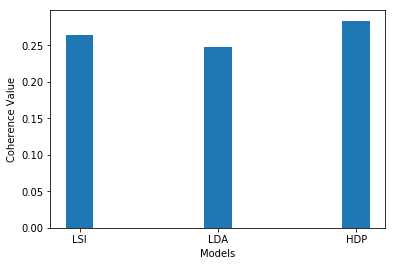

In [39]:
#evaluate_bar_graph([lsi_coherence], ['LSI'])
evaluate_bar_graph([lsi_coherence, lda_coherence, hdp_coherence], ['LSI', 'LDA', 'HDP'])

In [ ]:
#get topic distribution in each title -- see end of Zhao

In [33]:
'''keep: this is how to concat all text in a df column
all_text = df['text'].str.cat(sep=' '); print(type(all_text))
#all_text[1:500]
print(all_text[:500])
'''

<class 'str'>
Stirring message that Brother Pearry gave us just then from the Word of God. How true it is that “We limit God and time God; and He’s Eternal, we can’t do that.” So tonight we’re facing something else now, is communion. Three years I waited for a church to come in Tucson, but it’s here. Yeah, we’re here. So we thank the Lord, He just let us wait till we can appreciate it now. Now, there’s one thing that I’d want to say just before we start the communion, is this, that I believe that we have seen
